In [1]:
%cd -q data/actr_reco

In [2]:
# import powerlaw
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from scipy import stats

plt.rcParams['figure.dpi'] = 150

tqdm.tqdm.pandas()

# Calculate

In [5]:
# Values are sorted by timestamp
total_events = 135142263
chunksize = 100_000

col_names = ['user', 'track', 'artist', 'album', 'gender', 'country', 'age', 'timestamp']
reader = pd.read_csv("input/listening_events_2019.tsv.bz2", compression="bz2", names=col_names,
                    quoting=3, sep="\t", header=None, parse_dates=[7], encoding='utf-8',
                     chunksize=chunksize
#                      nrows=100_000  # out of 135142263
                    )

In [ ]:
lid_ts = {}
relisten_events = []

for chunk in tqdm.tqdm(reader, total=(total_events//chunksize + 1)):
    for _, row in chunk.iterrows():
        lid = tuple(row[["user", "track", "artist", "album"]])
        ts = row["timestamp"]
        
        if lid in lid_ts.keys():
            gap = ts - lid_ts[lid]
            relisten_events.append(gap)
        lid_ts[lid] = ts
len(relisten_events)

 42%|████▏     | 568/1352 [12:40:24<17:11:33, 78.95s/it]

In [ ]:
relisten_s = pd.Series(relisten_events)
relisten_s.describe()

In [ ]:
# relisten_s.to_csv("relisten_s.tsv.bz2", compression="bz2", quoting=3, sep="\t", header=None, encoding='utf-8')

In [3]:
relisten_s = pd.read_csv("relisten_s.tsv.bz2", compression="bz2", quoting=3, sep="\t", header=None, encoding='utf-8', index_col=0, parse_dates=[1])
relisten_s

/home/mreiterhaas/miniconda3/envs/polarice/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,1
0,
0,0 days 00:00:18
1,0 days 00:00:19
2,0 days 00:00:01
3,0 days 00:00:01
4,0 days 00:00:58
...,...
84654169,4 days 21:06:53
84654170,0 days 00:15:35
84654171,109 days 04:07:05


In [4]:
relisten_s = relisten_s.squeeze()

In [5]:
relisten_s = pd.to_timedelta(relisten_s)

# Plot

In [6]:
def plot_relistening_behavior(relisten_s, use_log=True, scatter=False, reg_line=True, filename="relistening.pdf", filter_criterion=None):
    plt.figure() 

    fig = plt.figure(figsize=[6.4, 3.6])
    fig.text(0.5, 0.005, 'Hours between Relistening (log)', ha='center', fontsize='12')
    fig.text(0.035, 0.5, '# Relistening Events (log)', va='center', rotation='vertical', fontsize='12')
    fig.suptitle("Relistening Behavior")

    # using hours is crucial for powerlaw, otherwise very low occurences are outliers
    scaling_factor = 3600 # 3600 used for hours, seconds seems completely weird, and minutes seems to be lognormal
    data = np.ceil(relisten_s.dt.total_seconds().dropna() / scaling_factor).value_counts()
    data = data[data.index != 0]
    x = data.index.tolist()
    y = data.values.tolist()
    plt.scatter(x, y, s=2)
    plt.ylim(bottom=0.8, top=5*10**7)
    plt.xlim(left=0.8)

    def plot_reg_line(x, y, color="orange", linestyle="solid"):
        # https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib/30672483
        log_x = np.log10(x)
        log_y = np.log10(y)
        coefficients = np.polyfit(log_x, log_y,  1)
        polynomial = np.poly1d(coefficients)
        ys = polynomial(log_x)
        b_exp = 10 ** np.array(log_x)
        ys_exp = 10 ** ys
        plt.plot(b_exp, ys_exp, color=color, linestyle=linestyle)
        print(f"{coefficients=}")
        
        # Calculate linreg coefficients, adapting solution of domkowald
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.log10(x),np.log10(y))
        print("R-squared (power): " + str(r_value**2))
        print("Slope: " + str(slope))
        print(f"{intercept=}")
    
    if reg_line:
        plot_reg_line(x, y)
        
    if filter_criterion:
        print("Applying filter criterion")
        relisten_s_filtered = relisten_s[relisten_s < filter_criterion]
        data = np.ceil(relisten_s_filtered.dt.total_seconds().dropna() / scaling_factor).value_counts()
        data = data[data.index != 0]
        x = data.index.tolist()
        y = data.values.tolist()
        plot_reg_line(x, y, color="red", linestyle="dashed")
    
    plt.xticks(fontsize='13')
    plt.yticks(fontsize='13')
    if use_log:
        plt.xscale('log')
        plt.yscale('log')

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

coefficients=array([-1.73652833,  9.10578503])
R-squared (power): 0.800740540815189
Slope: -1.7365283299928798
intercept=9.10578502639879


<Figure size 960x720 with 0 Axes>

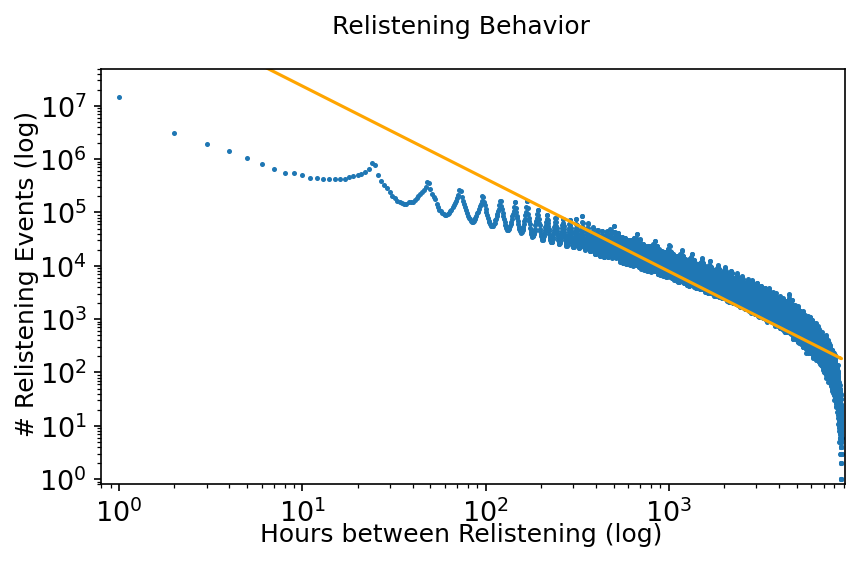

In [182]:
plot_relistening_behavior(relisten_s, scatter=True)

In [183]:
# Keep only relistenign < 7 days = 168 hours

filtered_relisten_s = relisten_s[relisten_s < pd.Timedelta(7, unit="days")]

coefficients=array([-0.85976828,  6.70185145])
R-squared (power): 0.8112820089046493
Slope: -0.8597682839329572
intercept=6.701851450952526


<Figure size 960x720 with 0 Axes>

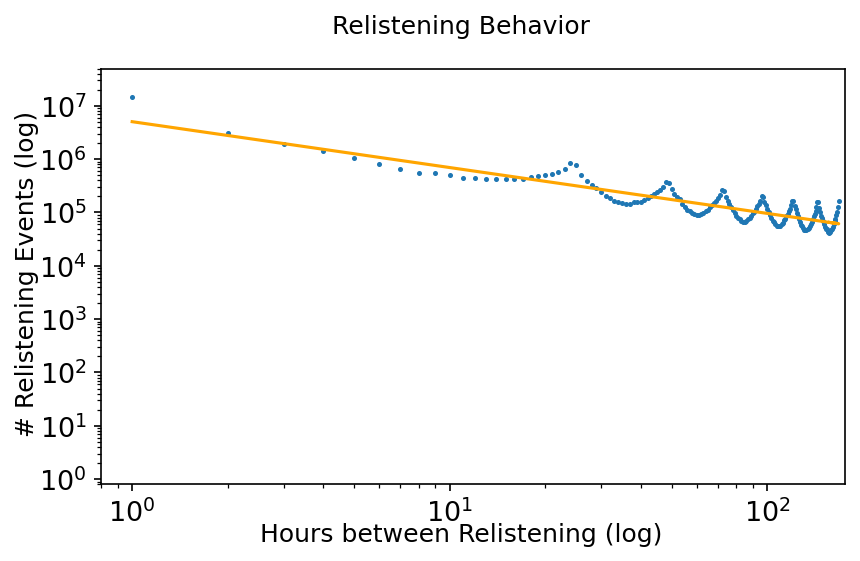

In [184]:
plot_relistening_behavior(filtered_relisten_s, scatter=True, filename="relistening_filtered.pdf")

coefficients=array([-1.73652833,  9.10578503])
R-squared (power): 0.800740540815189
Slope: -1.7365283299928798
intercept=9.10578502639879
Applying filter criterion
coefficients=array([-0.85976828,  6.70185145])
R-squared (power): 0.8112820089046493
Slope: -0.8597682839329572
intercept=6.701851450952526


<Figure size 960x720 with 0 Axes>

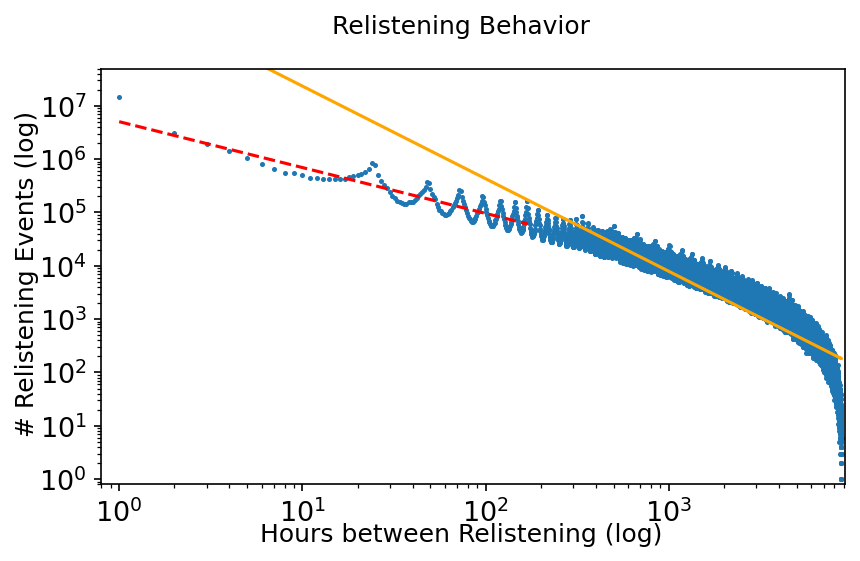

In [7]:
# Combine the two other plots
plot_relistening_behavior(relisten_s, scatter=True, filename="relistening_both.pdf", filter_criterion=pd.Timedelta(7, unit="days"))